In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b75'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k11_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_b10_b75_roi_t1_native_k5_b25_k11_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 382)
(1919620, 8)
validation
(288502, 382)
(288502, 8)
test
(221128, 382)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 382)]             0         


 dense (Dense)               (None, 2048)              784384    


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 3572616 (13.63 MB)


Trainable params: 3572616 (13.63 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 2:48 - loss: 2.2956 - STD: 0.0693 - MAE: 0.2185

 2/20 [==>...........................] - ETA: 5s - loss: 2.2157 - STD: 0.0541 - MAE: 0.2185  

 3/20 [===>..........................] - ETA: 4s - loss: 2.1719 - STD: 0.0421 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 4s - loss: 2.1529 - STD: 0.0374 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 4s - loss: 2.1460 - STD: 0.0372 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 4s - loss: 2.1423 - STD: 0.0373 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 3s - loss: 2.1378 - STD: 0.0365 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 3s - loss: 2.1324 - STD: 0.0346 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.1269 - STD: 0.0321 - MAE: 0.2187

10/20 [==============>...............] - ETA: 2s - loss: 2.1221 - STD: 0.0294 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.1183 - STD: 0.0278 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.1155 - STD: 0.0270 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.1135 - STD: 0.0265 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.1118 - STD: 0.0262 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.1103 - STD: 0.0260 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.1100 - STD: 0.0256 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.1085 - STD: 0.0251 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.1069 - STD: 0.0244 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.1054 - STD: 0.0236 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.1040 - STD: 0.0227 - MAE: 0.2187

20/20 [==============================] - 20s 576ms/step - loss: 2.1040 - STD: 0.0227 - MAE: 0.2187 - val_loss: 2.0777 - val_STD: 0.0063 - val_MAE: 0.2187


Epoch 2/10000


 1/20 [>.............................] - ETA: 7s - loss: 2.0789 - STD: 0.0063 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 5s - loss: 2.0794 - STD: 0.0076 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 5s - loss: 2.0800 - STD: 0.0087 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 4s - loss: 2.0806 - STD: 0.0095 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 4s - loss: 2.0809 - STD: 0.0099 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.0810 - STD: 0.0101 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 3s - loss: 2.0809 - STD: 0.0100 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 3s - loss: 2.0807 - STD: 0.0097 - MAE: 0.2187

 9/20 [============>.................] - ETA: 2s - loss: 2.0807 - STD: 0.0094 - MAE: 0.2187

10/20 [==============>...............] - ETA: 2s - loss: 2.0804 - STD: 0.0091 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.0802 - STD: 0.0089 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.0800 - STD: 0.0089 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.0800 - STD: 0.0090 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.0799 - STD: 0.0091 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0799 - STD: 0.0093 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0799 - STD: 0.0093 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0798 - STD: 0.0094 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0798 - STD: 0.0093 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0797 - STD: 0.0092 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0796 - STD: 0.0090 - MAE: 0.2187

20/20 [==============================] - 6s 312ms/step - loss: 2.0796 - STD: 0.0090 - MAE: 0.2187 - val_loss: 2.0770 - val_STD: 0.0063 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 8s - loss: 2.0782 - STD: 0.0063 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 5s - loss: 2.0783 - STD: 0.0065 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 5s - loss: 2.0785 - STD: 0.0068 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 3s - loss: 2.0785 - STD: 0.0070 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 3s - loss: 2.0786 - STD: 0.0070 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 3s - loss: 2.0786 - STD: 0.0070 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 3s - loss: 2.0786 - STD: 0.0068 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 3s - loss: 2.0785 - STD: 0.0067 - MAE: 0.2187

 9/20 [============>.................] - ETA: 2s - loss: 2.0785 - STD: 0.0066 - MAE: 0.2187

10/20 [==============>...............] - ETA: 2s - loss: 2.0784 - STD: 0.0066 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.0784 - STD: 0.0066 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.0784 - STD: 0.0067 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.0784 - STD: 0.0069 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.0784 - STD: 0.0070 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0784 - STD: 0.0070 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187

20/20 [==============================] - 6s 311ms/step - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187 - val_loss: 2.0769 - val_STD: 0.0066 - val_MAE: 0.2186


Epoch 4/10000


 1/20 [>.............................] - ETA: 8s - loss: 2.0779 - STD: 0.0066 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 5s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 5s - loss: 2.0781 - STD: 0.0067 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 4s - loss: 2.0782 - STD: 0.0067 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 4s - loss: 2.0782 - STD: 0.0066 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.0781 - STD: 0.0065 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 3s - loss: 2.0781 - STD: 0.0064 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 3s - loss: 2.0781 - STD: 0.0064 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.0781 - STD: 0.0064 - MAE: 0.2187

10/20 [==============>...............] - ETA: 2s - loss: 2.0780 - STD: 0.0065 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.0780 - STD: 0.0065 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.0780 - STD: 0.0066 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0780 - STD: 0.0067 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0780 - STD: 0.0066 - MAE: 0.2187

20/20 [==============================] - 6s 313ms/step - loss: 2.0780 - STD: 0.0066 - MAE: 0.2187 - val_loss: 2.0767 - val_STD: 0.0062 - val_MAE: 0.2186


Epoch 5/10000


 1/20 [>.............................] - ETA: 7s - loss: 2.0780 - STD: 0.0062 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 5s - loss: 2.0778 - STD: 0.0064 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 5s - loss: 2.0779 - STD: 0.0066 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 4s - loss: 2.0778 - STD: 0.0067 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 4s - loss: 2.0779 - STD: 0.0068 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.0778 - STD: 0.0068 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 3s - loss: 2.0778 - STD: 0.0068 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 3s - loss: 2.0778 - STD: 0.0068 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.0778 - STD: 0.0068 - MAE: 0.2187

10/20 [==============>...............] - ETA: 2s - loss: 2.0778 - STD: 0.0068 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.0777 - STD: 0.0068 - MAE: 0.2186

12/20 [=================>............] - ETA: 2s - loss: 2.0777 - STD: 0.0068 - MAE: 0.2186

13/20 [==================>...........] - ETA: 2s - loss: 2.0777 - STD: 0.0068 - MAE: 0.2186

14/20 [====================>.........] - ETA: 1s - loss: 2.0777 - STD: 0.0068 - MAE: 0.2186

15/20 [=====================>........] - ETA: 1s - loss: 2.0776 - STD: 0.0068 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.0776 - STD: 0.0067 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0775 - STD: 0.0067 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0775 - STD: 0.0068 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - 6s 316ms/step - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186 - val_loss: 2.0739 - val_STD: 0.0069 - val_MAE: 0.2185


Epoch 6/10000


 1/20 [>.............................] - ETA: 8s - loss: 2.0754 - STD: 0.0069 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 5s - loss: 2.0751 - STD: 0.0068 - MAE: 0.2186

 3/20 [===>..........................] - ETA: 5s - loss: 2.0748 - STD: 0.0068 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 4s - loss: 2.0745 - STD: 0.0067 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 4s - loss: 2.0741 - STD: 0.0067 - MAE: 0.2185

 6/20 [========>.....................] - ETA: 4s - loss: 2.0737 - STD: 0.0067 - MAE: 0.2185

 7/20 [=========>....................] - ETA: 3s - loss: 2.0731 - STD: 0.0068 - MAE: 0.2185

 8/20 [===========>..................] - ETA: 3s - loss: 2.0725 - STD: 0.0070 - MAE: 0.2185

 9/20 [============>.................] - ETA: 3s - loss: 2.0718 - STD: 0.0071 - MAE: 0.2185

10/20 [==============>...............] - ETA: 2s - loss: 2.0716 - STD: 0.0073 - MAE: 0.2184

11/20 [===============>..............] - ETA: 2s - loss: 2.0705 - STD: 0.0075 - MAE: 0.2184

12/20 [=================>............] - ETA: 2s - loss: 2.0693 - STD: 0.0077 - MAE: 0.2184

13/20 [==================>...........] - ETA: 1s - loss: 2.0678 - STD: 0.0081 - MAE: 0.2183

14/20 [====================>.........] - ETA: 1s - loss: 2.0662 - STD: 0.0084 - MAE: 0.2183

15/20 [=====================>........] - ETA: 1s - loss: 2.0643 - STD: 0.0089 - MAE: 0.2182

16/20 [=======================>......] - ETA: 1s - loss: 2.0621 - STD: 0.0094 - MAE: 0.2181

17/20 [========================>.....] - ETA: 0s - loss: 2.0597 - STD: 0.0101 - MAE: 0.2180

18/20 [==========================>...] - ETA: 0s - loss: 2.0572 - STD: 0.0109 - MAE: 0.2179

19/20 [===========================>..] - ETA: 0s - loss: 2.0545 - STD: 0.0119 - MAE: 0.2178

20/20 [==============================] - ETA: 0s - loss: 2.0512 - STD: 0.0128 - MAE: 0.2177

20/20 [==============================] - 6s 313ms/step - loss: 2.0512 - STD: 0.0128 - MAE: 0.2177 - val_loss: 1.9865 - val_STD: 0.0349 - val_MAE: 0.2147


Epoch 7/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.9815 - STD: 0.0351 - MAE: 0.2145

 2/20 [==>...........................] - ETA: 5s - loss: 1.9786 - STD: 0.0379 - MAE: 0.2142

 3/20 [===>..........................] - ETA: 5s - loss: 1.9723 - STD: 0.0396 - MAE: 0.2139

 4/20 [=====>........................] - ETA: 4s - loss: 1.9662 - STD: 0.0415 - MAE: 0.2135

 5/20 [======>.......................] - ETA: 4s - loss: 1.9616 - STD: 0.0438 - MAE: 0.2132

 6/20 [========>.....................] - ETA: 4s - loss: 1.9564 - STD: 0.0455 - MAE: 0.2128

 7/20 [=========>....................] - ETA: 3s - loss: 1.9509 - STD: 0.0473 - MAE: 0.2125

 8/20 [===========>..................] - ETA: 3s - loss: 1.9471 - STD: 0.0495 - MAE: 0.2121

 9/20 [============>.................] - ETA: 3s - loss: 1.9428 - STD: 0.0512 - MAE: 0.2118

10/20 [==============>...............] - ETA: 2s - loss: 1.9389 - STD: 0.0528 - MAE: 0.2115

11/20 [===============>..............] - ETA: 2s - loss: 1.9359 - STD: 0.0547 - MAE: 0.2112

12/20 [=================>............] - ETA: 2s - loss: 1.9328 - STD: 0.0561 - MAE: 0.2110

13/20 [==================>...........] - ETA: 2s - loss: 1.9295 - STD: 0.0573 - MAE: 0.2107

14/20 [====================>.........] - ETA: 1s - loss: 1.9267 - STD: 0.0587 - MAE: 0.2105

15/20 [=====================>........] - ETA: 1s - loss: 1.9238 - STD: 0.0598 - MAE: 0.2103

16/20 [=======================>......] - ETA: 1s - loss: 1.9216 - STD: 0.0607 - MAE: 0.2101

17/20 [========================>.....] - ETA: 0s - loss: 1.9193 - STD: 0.0616 - MAE: 0.2099

18/20 [==========================>...] - ETA: 0s - loss: 1.9188 - STD: 0.0624 - MAE: 0.2097

19/20 [===========================>..] - ETA: 0s - loss: 1.9166 - STD: 0.0630 - MAE: 0.2096

20/20 [==============================] - ETA: 0s - loss: 1.9143 - STD: 0.0635 - MAE: 0.2095

20/20 [==============================] - 6s 316ms/step - loss: 1.9143 - STD: 0.0635 - MAE: 0.2095 - val_loss: 1.9047 - val_STD: 0.0737 - val_MAE: 0.2082


Epoch 8/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.8697 - STD: 0.0748 - MAE: 0.2069

 2/20 [==>...........................] - ETA: 5s - loss: 1.8693 - STD: 0.0739 - MAE: 0.2070

 3/20 [===>..........................] - ETA: 5s - loss: 1.8667 - STD: 0.0740 - MAE: 0.2069

 4/20 [=====>........................] - ETA: 4s - loss: 1.8658 - STD: 0.0744 - MAE: 0.2068

 5/20 [======>.......................] - ETA: 4s - loss: 1.8656 - STD: 0.0745 - MAE: 0.2068

 6/20 [========>.....................] - ETA: 4s - loss: 1.8642 - STD: 0.0749 - MAE: 0.2067

 7/20 [=========>....................] - ETA: 3s - loss: 1.8629 - STD: 0.0753 - MAE: 0.2066

 8/20 [===========>..................] - ETA: 3s - loss: 1.8619 - STD: 0.0754 - MAE: 0.2065

 9/20 [============>.................] - ETA: 3s - loss: 1.8609 - STD: 0.0759 - MAE: 0.2064

10/20 [==============>...............] - ETA: 2s - loss: 1.8597 - STD: 0.0761 - MAE: 0.2064

11/20 [===============>..............] - ETA: 2s - loss: 1.8587 - STD: 0.0763 - MAE: 0.2063

12/20 [=================>............] - ETA: 2s - loss: 1.8575 - STD: 0.0766 - MAE: 0.2062

13/20 [==================>...........] - ETA: 2s - loss: 1.8568 - STD: 0.0768 - MAE: 0.2062

14/20 [====================>.........] - ETA: 1s - loss: 1.8557 - STD: 0.0772 - MAE: 0.2061

15/20 [=====================>........] - ETA: 1s - loss: 1.8556 - STD: 0.0774 - MAE: 0.2060

16/20 [=======================>......] - ETA: 1s - loss: 1.8540 - STD: 0.0776 - MAE: 0.2059

17/20 [========================>.....] - ETA: 0s - loss: 1.8527 - STD: 0.0779 - MAE: 0.2059

18/20 [==========================>...] - ETA: 0s - loss: 1.8517 - STD: 0.0780 - MAE: 0.2058

19/20 [===========================>..] - ETA: 0s - loss: 1.8509 - STD: 0.0784 - MAE: 0.2057

20/20 [==============================] - ETA: 0s - loss: 1.8499 - STD: 0.0785 - MAE: 0.2057

20/20 [==============================] - 6s 314ms/step - loss: 1.8499 - STD: 0.0785 - MAE: 0.2057 - val_loss: 1.8579 - val_STD: 0.0827 - val_MAE: 0.2053


Epoch 9/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.8209 - STD: 0.0837 - MAE: 0.2039

 2/20 [==>...........................] - ETA: 5s - loss: 1.8191 - STD: 0.0840 - MAE: 0.2038

 3/20 [===>..........................] - ETA: 5s - loss: 1.8208 - STD: 0.0831 - MAE: 0.2040

 4/20 [=====>........................] - ETA: 4s - loss: 1.8213 - STD: 0.0843 - MAE: 0.2038

 5/20 [======>.......................] - ETA: 4s - loss: 1.8206 - STD: 0.0840 - MAE: 0.2038

 6/20 [========>.....................] - ETA: 4s - loss: 1.8179 - STD: 0.0845 - MAE: 0.2037

 7/20 [=========>....................] - ETA: 3s - loss: 1.8158 - STD: 0.0849 - MAE: 0.2035

 8/20 [===========>..................] - ETA: 3s - loss: 1.8157 - STD: 0.0848 - MAE: 0.2035

 9/20 [============>.................] - ETA: 2s - loss: 1.8144 - STD: 0.0853 - MAE: 0.2034

10/20 [==============>...............] - ETA: 2s - loss: 1.8125 - STD: 0.0853 - MAE: 0.2033

11/20 [===============>..............] - ETA: 2s - loss: 1.8104 - STD: 0.0855 - MAE: 0.2032

12/20 [=================>............] - ETA: 2s - loss: 1.8082 - STD: 0.0859 - MAE: 0.2031

13/20 [==================>...........] - ETA: 1s - loss: 1.8067 - STD: 0.0859 - MAE: 0.2031

14/20 [====================>.........] - ETA: 1s - loss: 1.8055 - STD: 0.0864 - MAE: 0.2029

15/20 [=====================>........] - ETA: 1s - loss: 1.8046 - STD: 0.0864 - MAE: 0.2029

16/20 [=======================>......] - ETA: 1s - loss: 1.8033 - STD: 0.0868 - MAE: 0.2028

17/20 [========================>.....] - ETA: 0s - loss: 1.8017 - STD: 0.0868 - MAE: 0.2027

18/20 [==========================>...] - ETA: 0s - loss: 1.7994 - STD: 0.0871 - MAE: 0.2026

19/20 [===========================>..] - ETA: 0s - loss: 1.7973 - STD: 0.0873 - MAE: 0.2025

20/20 [==============================] - ETA: 0s - loss: 1.7954 - STD: 0.0875 - MAE: 0.2024

20/20 [==============================] - 6s 312ms/step - loss: 1.7954 - STD: 0.0875 - MAE: 0.2024 - val_loss: 1.8036 - val_STD: 0.0933 - val_MAE: 0.2018


Epoch 10/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.7627 - STD: 0.0948 - MAE: 0.2000

 2/20 [==>...........................] - ETA: 5s - loss: 1.7725 - STD: 0.0922 - MAE: 0.2009

 3/20 [===>..........................] - ETA: 5s - loss: 1.7854 - STD: 0.0945 - MAE: 0.2008

 4/20 [=====>........................] - ETA: 4s - loss: 1.7942 - STD: 0.0930 - MAE: 0.2014

 5/20 [======>.......................] - ETA: 4s - loss: 1.7829 - STD: 0.0927 - MAE: 0.2011

 6/20 [========>.....................] - ETA: 4s - loss: 1.7880 - STD: 0.0940 - MAE: 0.2010

 7/20 [=========>....................] - ETA: 3s - loss: 1.7918 - STD: 0.0934 - MAE: 0.2013

 8/20 [===========>..................] - ETA: 3s - loss: 1.7854 - STD: 0.0930 - MAE: 0.2011

 9/20 [============>.................] - ETA: 3s - loss: 1.7919 - STD: 0.0942 - MAE: 0.2011

10/20 [==============>...............] - ETA: 2s - loss: 1.7859 - STD: 0.0938 - MAE: 0.2010

11/20 [===============>..............] - ETA: 2s - loss: 1.7867 - STD: 0.0934 - MAE: 0.2011

12/20 [=================>............] - ETA: 2s - loss: 1.7855 - STD: 0.0932 - MAE: 0.2009

13/20 [==================>...........] - ETA: 1s - loss: 1.7849 - STD: 0.0936 - MAE: 0.2009

14/20 [====================>.........] - ETA: 1s - loss: 1.7802 - STD: 0.0935 - MAE: 0.2007

15/20 [=====================>........] - ETA: 1s - loss: 1.7780 - STD: 0.0934 - MAE: 0.2007

16/20 [=======================>......] - ETA: 1s - loss: 1.7738 - STD: 0.0936 - MAE: 0.2005

17/20 [========================>.....] - ETA: 0s - loss: 1.7711 - STD: 0.0939 - MAE: 0.2004

18/20 [==========================>...] - ETA: 0s - loss: 1.7676 - STD: 0.0939 - MAE: 0.2003

19/20 [===========================>..] - ETA: 0s - loss: 1.7644 - STD: 0.0939 - MAE: 0.2002

20/20 [==============================] - ETA: 0s - loss: 1.7613 - STD: 0.0941 - MAE: 0.2001

20/20 [==============================] - 6s 314ms/step - loss: 1.7613 - STD: 0.0941 - MAE: 0.2001 - val_loss: 1.7195 - val_STD: 0.0965 - val_MAE: 0.1983


Epoch 11/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.6851 - STD: 0.0984 - MAE: 0.1966

 2/20 [==>...........................] - ETA: 5s - loss: 1.6900 - STD: 0.0990 - MAE: 0.1967

 3/20 [===>..........................] - ETA: 5s - loss: 1.6830 - STD: 0.0996 - MAE: 0.1964

 4/20 [=====>........................] - ETA: 4s - loss: 1.6844 - STD: 0.1005 - MAE: 0.1962

 5/20 [======>.......................] - ETA: 4s - loss: 1.6801 - STD: 0.1008 - MAE: 0.1960

 6/20 [========>.....................] - ETA: 4s - loss: 1.6776 - STD: 0.1013 - MAE: 0.1958

 7/20 [=========>....................] - ETA: 3s - loss: 1.6754 - STD: 0.1016 - MAE: 0.1957

 8/20 [===========>..................] - ETA: 3s - loss: 1.6713 - STD: 0.1020 - MAE: 0.1955

 9/20 [============>.................] - ETA: 3s - loss: 1.6691 - STD: 0.1025 - MAE: 0.1953

10/20 [==============>...............] - ETA: 2s - loss: 1.6663 - STD: 0.1031 - MAE: 0.1951

11/20 [===============>..............] - ETA: 2s - loss: 1.6643 - STD: 0.1037 - MAE: 0.1949

12/20 [=================>............] - ETA: 2s - loss: 1.6626 - STD: 0.1043 - MAE: 0.1947

13/20 [==================>...........] - ETA: 2s - loss: 1.6604 - STD: 0.1048 - MAE: 0.1945

14/20 [====================>.........] - ETA: 1s - loss: 1.6584 - STD: 0.1052 - MAE: 0.1943

15/20 [=====================>........] - ETA: 1s - loss: 1.6566 - STD: 0.1056 - MAE: 0.1942

16/20 [=======================>......] - ETA: 1s - loss: 1.6545 - STD: 0.1060 - MAE: 0.1940

17/20 [========================>.....] - ETA: 0s - loss: 1.6541 - STD: 0.1064 - MAE: 0.1939

18/20 [==========================>...] - ETA: 0s - loss: 1.6525 - STD: 0.1068 - MAE: 0.1937

19/20 [===========================>..] - ETA: 0s - loss: 1.6509 - STD: 0.1072 - MAE: 0.1936

20/20 [==============================] - ETA: 0s - loss: 1.6492 - STD: 0.1076 - MAE: 0.1935

20/20 [==============================] - 6s 313ms/step - loss: 1.6492 - STD: 0.1076 - MAE: 0.1935 - val_loss: 1.6444 - val_STD: 0.1128 - val_MAE: 0.1923


Epoch 12/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.6196 - STD: 0.1145 - MAE: 0.1909

 2/20 [==>...........................] - ETA: 5s - loss: 1.6218 - STD: 0.1141 - MAE: 0.1911

 3/20 [===>..........................] - ETA: 5s - loss: 1.6217 - STD: 0.1146 - MAE: 0.1910

 4/20 [=====>........................] - ETA: 4s - loss: 1.6199 - STD: 0.1147 - MAE: 0.1909

 5/20 [======>.......................] - ETA: 4s - loss: 1.6171 - STD: 0.1150 - MAE: 0.1907

 6/20 [========>.....................] - ETA: 4s - loss: 1.6152 - STD: 0.1153 - MAE: 0.1906

 7/20 [=========>....................] - ETA: 3s - loss: 1.6135 - STD: 0.1156 - MAE: 0.1905

 8/20 [===========>..................] - ETA: 3s - loss: 1.6133 - STD: 0.1159 - MAE: 0.1904

 9/20 [============>.................] - ETA: 3s - loss: 1.6131 - STD: 0.1160 - MAE: 0.1903

10/20 [==============>...............] - ETA: 2s - loss: 1.6128 - STD: 0.1162 - MAE: 0.1903

11/20 [===============>..............] - ETA: 2s - loss: 1.6117 - STD: 0.1162 - MAE: 0.1902

12/20 [=================>............] - ETA: 2s - loss: 1.6109 - STD: 0.1163 - MAE: 0.1902

13/20 [==================>...........] - ETA: 2s - loss: 1.6099 - STD: 0.1165 - MAE: 0.1901

14/20 [====================>.........] - ETA: 1s - loss: 1.6094 - STD: 0.1167 - MAE: 0.1901

15/20 [=====================>........] - ETA: 1s - loss: 1.6093 - STD: 0.1169 - MAE: 0.1900

16/20 [=======================>......] - ETA: 1s - loss: 1.6085 - STD: 0.1170 - MAE: 0.1899

17/20 [========================>.....] - ETA: 0s - loss: 1.6075 - STD: 0.1170 - MAE: 0.1899

18/20 [==========================>...] - ETA: 0s - loss: 1.6069 - STD: 0.1171 - MAE: 0.1898

19/20 [===========================>..] - ETA: 0s - loss: 1.6062 - STD: 0.1173 - MAE: 0.1898

20/20 [==============================] - ETA: 0s - loss: 1.6058 - STD: 0.1175 - MAE: 0.1897

20/20 [==============================] - 7s 374ms/step - loss: 1.6058 - STD: 0.1175 - MAE: 0.1897 - val_loss: 1.6281 - val_STD: 0.1188 - val_MAE: 0.1904


Epoch 13/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.5923 - STD: 0.1206 - MAE: 0.1885

 2/20 [==>...........................] - ETA: 1s - loss: 1.5909 - STD: 0.1209 - MAE: 0.1882 

 3/20 [===>..........................] - ETA: 3s - loss: 1.5884 - STD: 0.1206 - MAE: 0.1883

 4/20 [=====>........................] - ETA: 4s - loss: 1.5869 - STD: 0.1205 - MAE: 0.1883

 5/20 [======>.......................] - ETA: 4s - loss: 1.5879 - STD: 0.1207 - MAE: 0.1883

 6/20 [========>.....................] - ETA: 4s - loss: 1.5884 - STD: 0.1207 - MAE: 0.1883

 7/20 [=========>....................] - ETA: 3s - loss: 1.5900 - STD: 0.1210 - MAE: 0.1882

 8/20 [===========>..................] - ETA: 3s - loss: 1.5914 - STD: 0.1211 - MAE: 0.1883

 9/20 [============>.................] - ETA: 3s - loss: 1.5922 - STD: 0.1212 - MAE: 0.1883

10/20 [==============>...............] - ETA: 3s - loss: 1.5913 - STD: 0.1212 - MAE: 0.1882

11/20 [===============>..............] - ETA: 2s - loss: 1.5904 - STD: 0.1214 - MAE: 0.1881

12/20 [=================>............] - ETA: 2s - loss: 1.5894 - STD: 0.1215 - MAE: 0.1881

13/20 [==================>...........] - ETA: 2s - loss: 1.5890 - STD: 0.1216 - MAE: 0.1881

14/20 [====================>.........] - ETA: 1s - loss: 1.5891 - STD: 0.1218 - MAE: 0.1880

15/20 [=====================>........] - ETA: 1s - loss: 1.5889 - STD: 0.1219 - MAE: 0.1880

16/20 [=======================>......] - ETA: 1s - loss: 1.5882 - STD: 0.1219 - MAE: 0.1879

17/20 [========================>.....] - ETA: 0s - loss: 1.5875 - STD: 0.1220 - MAE: 0.1879

18/20 [==========================>...] - ETA: 0s - loss: 1.5864 - STD: 0.1220 - MAE: 0.1878

19/20 [===========================>..] - ETA: 0s - loss: 1.5861 - STD: 0.1221 - MAE: 0.1878

20/20 [==============================] - ETA: 0s - loss: 1.5854 - STD: 0.1222 - MAE: 0.1877

20/20 [==============================] - 7s 355ms/step - loss: 1.5854 - STD: 0.1222 - MAE: 0.1877 - val_loss: 1.6049 - val_STD: 0.1225 - val_MAE: 0.1883


Epoch 14/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.5666 - STD: 0.1252 - MAE: 0.1862

 2/20 [==>...........................] - ETA: 5s - loss: 1.5692 - STD: 0.1241 - MAE: 0.1865 

 3/20 [===>..........................] - ETA: 5s - loss: 1.5689 - STD: 0.1238 - MAE: 0.1866

 4/20 [=====>........................] - ETA: 3s - loss: 1.5691 - STD: 0.1241 - MAE: 0.1866

 5/20 [======>.......................] - ETA: 3s - loss: 1.5710 - STD: 0.1239 - MAE: 0.1867

 6/20 [========>.....................] - ETA: 3s - loss: 1.5707 - STD: 0.1242 - MAE: 0.1866

 7/20 [=========>....................] - ETA: 3s - loss: 1.5697 - STD: 0.1243 - MAE: 0.1865

 8/20 [===========>..................] - ETA: 3s - loss: 1.5688 - STD: 0.1243 - MAE: 0.1865

 9/20 [============>.................] - ETA: 3s - loss: 1.5679 - STD: 0.1244 - MAE: 0.1864

10/20 [==============>...............] - ETA: 2s - loss: 1.5673 - STD: 0.1245 - MAE: 0.1864

11/20 [===============>..............] - ETA: 2s - loss: 1.5672 - STD: 0.1246 - MAE: 0.1863

12/20 [=================>............] - ETA: 2s - loss: 1.5666 - STD: 0.1247 - MAE: 0.1863

13/20 [==================>...........] - ETA: 2s - loss: 1.5661 - STD: 0.1249 - MAE: 0.1862

14/20 [====================>.........] - ETA: 1s - loss: 1.5663 - STD: 0.1250 - MAE: 0.1862

15/20 [=====================>........] - ETA: 1s - loss: 1.5663 - STD: 0.1253 - MAE: 0.1861

16/20 [=======================>......] - ETA: 1s - loss: 1.5655 - STD: 0.1253 - MAE: 0.1861

17/20 [========================>.....] - ETA: 0s - loss: 1.5652 - STD: 0.1254 - MAE: 0.1860

18/20 [==========================>...] - ETA: 0s - loss: 1.5648 - STD: 0.1255 - MAE: 0.1860

19/20 [===========================>..] - ETA: 0s - loss: 1.5641 - STD: 0.1255 - MAE: 0.1860

20/20 [==============================] - ETA: 0s - loss: 1.5634 - STD: 0.1256 - MAE: 0.1859

20/20 [==============================] - 8s 374ms/step - loss: 1.5634 - STD: 0.1256 - MAE: 0.1859 - val_loss: 1.5898 - val_STD: 0.1261 - val_MAE: 0.1867


Epoch 15/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.5460 - STD: 0.1281 - MAE: 0.1844

 2/20 [==>...........................] - ETA: 5s - loss: 1.5483 - STD: 0.1279 - MAE: 0.1846 

 3/20 [===>..........................] - ETA: 5s - loss: 1.5479 - STD: 0.1281 - MAE: 0.1845

 4/20 [=====>........................] - ETA: 5s - loss: 1.5476 - STD: 0.1281 - MAE: 0.1845

 5/20 [======>.......................] - ETA: 4s - loss: 1.5474 - STD: 0.1281 - MAE: 0.1845

 6/20 [========>.....................] - ETA: 4s - loss: 1.5474 - STD: 0.1285 - MAE: 0.1844

 7/20 [=========>....................] - ETA: 4s - loss: 1.5507 - STD: 0.1285 - MAE: 0.1845

 8/20 [===========>..................] - ETA: 3s - loss: 1.5546 - STD: 0.1291 - MAE: 0.1845

 9/20 [============>.................] - ETA: 3s - loss: 1.5574 - STD: 0.1291 - MAE: 0.1846

10/20 [==============>...............] - ETA: 3s - loss: 1.5599 - STD: 0.1290 - MAE: 0.1847

11/20 [===============>..............] - ETA: 3s - loss: 1.5605 - STD: 0.1292 - MAE: 0.1847

12/20 [=================>............] - ETA: 2s - loss: 1.5602 - STD: 0.1290 - MAE: 0.1847

13/20 [==================>...........] - ETA: 2s - loss: 1.5595 - STD: 0.1289 - MAE: 0.1847

14/20 [====================>.........] - ETA: 1s - loss: 1.5600 - STD: 0.1291 - MAE: 0.1846

15/20 [=====================>........] - ETA: 1s - loss: 1.5597 - STD: 0.1292 - MAE: 0.1846

16/20 [=======================>......] - ETA: 1s - loss: 1.5596 - STD: 0.1292 - MAE: 0.1846

17/20 [========================>.....] - ETA: 0s - loss: 1.5590 - STD: 0.1295 - MAE: 0.1845

18/20 [==========================>...] - ETA: 0s - loss: 1.5577 - STD: 0.1295 - MAE: 0.1844

19/20 [===========================>..] - ETA: 0s - loss: 1.5578 - STD: 0.1296 - MAE: 0.1844

20/20 [==============================] - ETA: 0s - loss: 1.5573 - STD: 0.1296 - MAE: 0.1844

20/20 [==============================] - 8s 378ms/step - loss: 1.5573 - STD: 0.1296 - MAE: 0.1844 - val_loss: 1.5761 - val_STD: 0.1280 - val_MAE: 0.1854


Epoch 16/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.5382 - STD: 0.1297 - MAE: 0.1836

 2/20 [==>...........................] - ETA: 6s - loss: 1.5423 - STD: 0.1290 - MAE: 0.1840 

 3/20 [===>..........................] - ETA: 5s - loss: 1.5377 - STD: 0.1291 - MAE: 0.1837

 4/20 [=====>........................] - ETA: 5s - loss: 1.5399 - STD: 0.1298 - MAE: 0.1836

 5/20 [======>.......................] - ETA: 3s - loss: 1.5394 - STD: 0.1299 - MAE: 0.1836

 6/20 [========>.....................] - ETA: 3s - loss: 1.5383 - STD: 0.1300 - MAE: 0.1835

 7/20 [=========>....................] - ETA: 3s - loss: 1.5372 - STD: 0.1304 - MAE: 0.1834

 8/20 [===========>..................] - ETA: 3s - loss: 1.5358 - STD: 0.1306 - MAE: 0.1833

 9/20 [============>.................] - ETA: 3s - loss: 1.5354 - STD: 0.1307 - MAE: 0.1832

10/20 [==============>...............] - ETA: 3s - loss: 1.5348 - STD: 0.1310 - MAE: 0.1831

11/20 [===============>..............] - ETA: 2s - loss: 1.5337 - STD: 0.1312 - MAE: 0.1830

12/20 [=================>............] - ETA: 2s - loss: 1.5330 - STD: 0.1313 - MAE: 0.1830

13/20 [==================>...........] - ETA: 2s - loss: 1.5320 - STD: 0.1314 - MAE: 0.1829

14/20 [====================>.........] - ETA: 1s - loss: 1.5318 - STD: 0.1315 - MAE: 0.1828

15/20 [=====================>........] - ETA: 1s - loss: 1.5319 - STD: 0.1316 - MAE: 0.1828

16/20 [=======================>......] - ETA: 1s - loss: 1.5310 - STD: 0.1317 - MAE: 0.1828

17/20 [========================>.....] - ETA: 0s - loss: 1.5306 - STD: 0.1318 - MAE: 0.1827

18/20 [==========================>...] - ETA: 0s - loss: 1.5302 - STD: 0.1319 - MAE: 0.1827

19/20 [===========================>..] - ETA: 0s - loss: 1.5294 - STD: 0.1321 - MAE: 0.1826

20/20 [==============================] - ETA: 0s - loss: 1.5286 - STD: 0.1322 - MAE: 0.1825

20/20 [==============================] - 8s 379ms/step - loss: 1.5286 - STD: 0.1322 - MAE: 0.1825 - val_loss: 1.5635 - val_STD: 0.1323 - val_MAE: 0.1839


Epoch 17/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.5193 - STD: 0.1338 - MAE: 0.1816

 2/20 [==>...........................] - ETA: 6s - loss: 1.5183 - STD: 0.1347 - MAE: 0.1814 

 3/20 [===>..........................] - ETA: 5s - loss: 1.5179 - STD: 0.1345 - MAE: 0.1814

 4/20 [=====>........................] - ETA: 5s - loss: 1.5179 - STD: 0.1347 - MAE: 0.1813

 5/20 [======>.......................] - ETA: 5s - loss: 1.5195 - STD: 0.1347 - MAE: 0.1814

 6/20 [========>.....................] - ETA: 4s - loss: 1.5208 - STD: 0.1349 - MAE: 0.1814

 7/20 [=========>....................] - ETA: 4s - loss: 1.5218 - STD: 0.1350 - MAE: 0.1814

 8/20 [===========>..................] - ETA: 4s - loss: 1.5231 - STD: 0.1352 - MAE: 0.1814

 9/20 [============>.................] - ETA: 3s - loss: 1.5232 - STD: 0.1353 - MAE: 0.1814

10/20 [==============>...............] - ETA: 3s - loss: 1.5221 - STD: 0.1354 - MAE: 0.1813

11/20 [===============>..............] - ETA: 3s - loss: 1.5202 - STD: 0.1354 - MAE: 0.1812

12/20 [=================>............] - ETA: 2s - loss: 1.5188 - STD: 0.1354 - MAE: 0.1811

13/20 [==================>...........] - ETA: 2s - loss: 1.5184 - STD: 0.1355 - MAE: 0.1811

14/20 [====================>.........] - ETA: 2s - loss: 1.5185 - STD: 0.1356 - MAE: 0.1811

15/20 [=====================>........] - ETA: 1s - loss: 1.5177 - STD: 0.1358 - MAE: 0.1810

16/20 [=======================>......] - ETA: 1s - loss: 1.5166 - STD: 0.1359 - MAE: 0.1809

17/20 [========================>.....] - ETA: 1s - loss: 1.5154 - STD: 0.1360 - MAE: 0.1808

18/20 [==========================>...] - ETA: 0s - loss: 1.5147 - STD: 0.1361 - MAE: 0.1808

19/20 [===========================>..] - ETA: 0s - loss: 1.5145 - STD: 0.1361 - MAE: 0.1807

20/20 [==============================] - ETA: 0s - loss: 1.5144 - STD: 0.1363 - MAE: 0.1807

20/20 [==============================] - 8s 381ms/step - loss: 1.5144 - STD: 0.1363 - MAE: 0.1807 - val_loss: 1.5508 - val_STD: 0.1363 - val_MAE: 0.1823


Epoch 18/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.4980 - STD: 0.1374 - MAE: 0.1797

 2/20 [==>...........................] - ETA: 6s - loss: 1.4989 - STD: 0.1379 - MAE: 0.1796 

 3/20 [===>..........................] - ETA: 5s - loss: 1.5000 - STD: 0.1379 - MAE: 0.1796

 4/20 [=====>........................] - ETA: 5s - loss: 1.5033 - STD: 0.1381 - MAE: 0.1797

 5/20 [======>.......................] - ETA: 4s - loss: 1.5057 - STD: 0.1380 - MAE: 0.1798

 6/20 [========>.....................] - ETA: 4s - loss: 1.5040 - STD: 0.1380 - MAE: 0.1798

 7/20 [=========>....................] - ETA: 4s - loss: 1.5022 - STD: 0.1379 - MAE: 0.1797

 8/20 [===========>..................] - ETA: 3s - loss: 1.5031 - STD: 0.1384 - MAE: 0.1796

 9/20 [============>.................] - ETA: 3s - loss: 1.5085 - STD: 0.1387 - MAE: 0.1797

10/20 [==============>...............] - ETA: 3s - loss: 1.5120 - STD: 0.1394 - MAE: 0.1797

11/20 [===============>..............] - ETA: 2s - loss: 1.5111 - STD: 0.1393 - MAE: 0.1797

12/20 [=================>............] - ETA: 2s - loss: 1.5108 - STD: 0.1393 - MAE: 0.1796

13/20 [==================>...........] - ETA: 2s - loss: 1.5114 - STD: 0.1393 - MAE: 0.1797

14/20 [====================>.........] - ETA: 1s - loss: 1.5112 - STD: 0.1392 - MAE: 0.1797

15/20 [=====================>........] - ETA: 1s - loss: 1.5094 - STD: 0.1391 - MAE: 0.1796

16/20 [=======================>......] - ETA: 1s - loss: 1.5089 - STD: 0.1391 - MAE: 0.1796

17/20 [========================>.....] - ETA: 0s - loss: 1.5090 - STD: 0.1391 - MAE: 0.1796

18/20 [==========================>...] - ETA: 0s - loss: 1.5072 - STD: 0.1391 - MAE: 0.1796

19/20 [===========================>..] - ETA: 0s - loss: 1.5063 - STD: 0.1391 - MAE: 0.1795

20/20 [==============================] - ETA: 0s - loss: 1.5066 - STD: 0.1391 - MAE: 0.1795

20/20 [==============================] - 7s 347ms/step - loss: 1.5066 - STD: 0.1391 - MAE: 0.1795 - val_loss: 1.5376 - val_STD: 0.1373 - val_MAE: 0.1813


Epoch 19/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.4824 - STD: 0.1386 - MAE: 0.1786

 2/20 [==>...........................] - ETA: 5s - loss: 1.4882 - STD: 0.1400 - MAE: 0.1785

 3/20 [===>..........................] - ETA: 5s - loss: 1.4901 - STD: 0.1400 - MAE: 0.1786

 4/20 [=====>........................] - ETA: 3s - loss: 1.4891 - STD: 0.1401 - MAE: 0.1784

 5/20 [======>.......................] - ETA: 3s - loss: 1.4876 - STD: 0.1403 - MAE: 0.1783

 6/20 [========>.....................] - ETA: 3s - loss: 1.4893 - STD: 0.1402 - MAE: 0.1784

 7/20 [=========>....................] - ETA: 3s - loss: 1.4875 - STD: 0.1403 - MAE: 0.1783

 8/20 [===========>..................] - ETA: 3s - loss: 1.4871 - STD: 0.1402 - MAE: 0.1783

 9/20 [============>.................] - ETA: 3s - loss: 1.4880 - STD: 0.1403 - MAE: 0.1783

10/20 [==============>...............] - ETA: 2s - loss: 1.4863 - STD: 0.1404 - MAE: 0.1783

11/20 [===============>..............] - ETA: 2s - loss: 1.4850 - STD: 0.1404 - MAE: 0.1782

12/20 [=================>............] - ETA: 2s - loss: 1.4852 - STD: 0.1405 - MAE: 0.1782

13/20 [==================>...........] - ETA: 2s - loss: 1.4845 - STD: 0.1405 - MAE: 0.1782

14/20 [====================>.........] - ETA: 1s - loss: 1.4831 - STD: 0.1406 - MAE: 0.1781

15/20 [=====================>........] - ETA: 1s - loss: 1.4823 - STD: 0.1406 - MAE: 0.1781

16/20 [=======================>......] - ETA: 1s - loss: 1.4820 - STD: 0.1407 - MAE: 0.1780

17/20 [========================>.....] - ETA: 0s - loss: 1.4812 - STD: 0.1407 - MAE: 0.1780

18/20 [==========================>...] - ETA: 0s - loss: 1.4802 - STD: 0.1408 - MAE: 0.1779

19/20 [===========================>..] - ETA: 0s - loss: 1.4797 - STD: 0.1409 - MAE: 0.1779

20/20 [==============================] - ETA: 0s - loss: 1.4798 - STD: 0.1410 - MAE: 0.1778

20/20 [==============================] - 7s 335ms/step - loss: 1.4798 - STD: 0.1410 - MAE: 0.1778 - val_loss: 1.5454 - val_STD: 0.1436 - val_MAE: 0.1795


Epoch 20/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.4825 - STD: 0.1449 - MAE: 0.1770

 2/20 [==>...........................] - ETA: 5s - loss: 1.4849 - STD: 0.1441 - MAE: 0.1774

 3/20 [===>..........................] - ETA: 5s - loss: 1.4937 - STD: 0.1448 - MAE: 0.1775

 4/20 [=====>........................] - ETA: 5s - loss: 1.5027 - STD: 0.1443 - MAE: 0.1780

 5/20 [======>.......................] - ETA: 4s - loss: 1.4975 - STD: 0.1440 - MAE: 0.1779

 6/20 [========>.....................] - ETA: 4s - loss: 1.4911 - STD: 0.1435 - MAE: 0.1777

 7/20 [=========>....................] - ETA: 4s - loss: 1.4917 - STD: 0.1434 - MAE: 0.1778

 8/20 [===========>..................] - ETA: 3s - loss: 1.4911 - STD: 0.1436 - MAE: 0.1777

 9/20 [============>.................] - ETA: 3s - loss: 1.4880 - STD: 0.1436 - MAE: 0.1775

10/20 [==============>...............] - ETA: 3s - loss: 1.4863 - STD: 0.1435 - MAE: 0.1775

11/20 [===============>..............] - ETA: 2s - loss: 1.4849 - STD: 0.1435 - MAE: 0.1774

12/20 [=================>............] - ETA: 2s - loss: 1.4818 - STD: 0.1434 - MAE: 0.1773

13/20 [==================>...........] - ETA: 2s - loss: 1.4793 - STD: 0.1433 - MAE: 0.1772

14/20 [====================>.........] - ETA: 1s - loss: 1.4782 - STD: 0.1434 - MAE: 0.1771

15/20 [=====================>........] - ETA: 1s - loss: 1.4765 - STD: 0.1433 - MAE: 0.1771

16/20 [=======================>......] - ETA: 1s - loss: 1.4748 - STD: 0.1433 - MAE: 0.1770

17/20 [========================>.....] - ETA: 0s - loss: 1.4746 - STD: 0.1435 - MAE: 0.1769

18/20 [==========================>...] - ETA: 0s - loss: 1.4744 - STD: 0.1435 - MAE: 0.1769

19/20 [===========================>..] - ETA: 0s - loss: 1.4751 - STD: 0.1436 - MAE: 0.1769

20/20 [==============================] - ETA: 0s - loss: 1.4779 - STD: 0.1437 - MAE: 0.1769

20/20 [==============================] - 7s 339ms/step - loss: 1.4779 - STD: 0.1437 - MAE: 0.1769 - val_loss: 1.5479 - val_STD: 0.1448 - val_MAE: 0.1794


Epoch 21/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.4797 - STD: 0.1463 - MAE: 0.1762

 2/20 [==>...........................] - ETA: 5s - loss: 1.4602 - STD: 0.1456 - MAE: 0.1756

 3/20 [===>..........................] - ETA: 5s - loss: 1.4608 - STD: 0.1457 - MAE: 0.1756

 4/20 [=====>........................] - ETA: 5s - loss: 1.4632 - STD: 0.1456 - MAE: 0.1757

 5/20 [======>.......................] - ETA: 3s - loss: 1.4628 - STD: 0.1454 - MAE: 0.1757

 6/20 [========>.....................] - ETA: 3s - loss: 1.4630 - STD: 0.1454 - MAE: 0.1758

 7/20 [=========>....................] - ETA: 3s - loss: 1.4631 - STD: 0.1451 - MAE: 0.1759

 8/20 [===========>..................] - ETA: 3s - loss: 1.4596 - STD: 0.1448 - MAE: 0.1758

 9/20 [============>.................] - ETA: 3s - loss: 1.4598 - STD: 0.1448 - MAE: 0.1758

10/20 [==============>...............] - ETA: 2s - loss: 1.4616 - STD: 0.1448 - MAE: 0.1759

11/20 [===============>..............] - ETA: 2s - loss: 1.4610 - STD: 0.1450 - MAE: 0.1758

12/20 [=================>............] - ETA: 2s - loss: 1.4614 - STD: 0.1452 - MAE: 0.1758

13/20 [==================>...........] - ETA: 2s - loss: 1.4600 - STD: 0.1452 - MAE: 0.1757

14/20 [====================>.........] - ETA: 1s - loss: 1.4584 - STD: 0.1453 - MAE: 0.1756

15/20 [=====================>........] - ETA: 1s - loss: 1.4590 - STD: 0.1455 - MAE: 0.1756

16/20 [=======================>......] - ETA: 1s - loss: 1.4590 - STD: 0.1455 - MAE: 0.1756

17/20 [========================>.....] - ETA: 0s - loss: 1.4584 - STD: 0.1456 - MAE: 0.1756

18/20 [==========================>...] - ETA: 0s - loss: 1.4580 - STD: 0.1456 - MAE: 0.1755

19/20 [===========================>..] - ETA: 0s - loss: 1.4574 - STD: 0.1456 - MAE: 0.1755

20/20 [==============================] - ETA: 0s - loss: 1.4555 - STD: 0.1456 - MAE: 0.1755

20/20 [==============================] - 7s 345ms/step - loss: 1.4555 - STD: 0.1456 - MAE: 0.1755 - val_loss: 1.5256 - val_STD: 0.1454 - val_MAE: 0.1780


Epoch 22/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.4396 - STD: 0.1463 - MAE: 0.1746

 2/20 [==>...........................] - ETA: 5s - loss: 1.4407 - STD: 0.1461 - MAE: 0.1747 

 3/20 [===>..........................] - ETA: 5s - loss: 1.4417 - STD: 0.1466 - MAE: 0.1746

 4/20 [=====>........................] - ETA: 5s - loss: 1.4466 - STD: 0.1467 - MAE: 0.1747

 5/20 [======>.......................] - ETA: 4s - loss: 1.4468 - STD: 0.1469 - MAE: 0.1747

 6/20 [========>.....................] - ETA: 4s - loss: 1.4454 - STD: 0.1468 - MAE: 0.1747

 7/20 [=========>....................] - ETA: 4s - loss: 1.4440 - STD: 0.1469 - MAE: 0.1746

 8/20 [===========>..................] - ETA: 3s - loss: 1.4419 - STD: 0.1468 - MAE: 0.1745

 9/20 [============>.................] - ETA: 3s - loss: 1.4396 - STD: 0.1468 - MAE: 0.1744

10/20 [==============>...............] - ETA: 2s - loss: 1.4394 - STD: 0.1469 - MAE: 0.1743

11/20 [===============>..............] - ETA: 2s - loss: 1.4385 - STD: 0.1469 - MAE: 0.1743

12/20 [=================>............] - ETA: 2s - loss: 1.4388 - STD: 0.1471 - MAE: 0.1742

13/20 [==================>...........] - ETA: 2s - loss: 1.4406 - STD: 0.1473 - MAE: 0.1743

14/20 [====================>.........] - ETA: 1s - loss: 1.4424 - STD: 0.1475 - MAE: 0.1743

15/20 [=====================>........] - ETA: 1s - loss: 1.4435 - STD: 0.1477 - MAE: 0.1743

16/20 [=======================>......] - ETA: 1s - loss: 1.4427 - STD: 0.1478 - MAE: 0.1742

17/20 [========================>.....] - ETA: 0s - loss: 1.4414 - STD: 0.1479 - MAE: 0.1741

18/20 [==========================>...] - ETA: 0s - loss: 1.4401 - STD: 0.1479 - MAE: 0.1741

19/20 [===========================>..] - ETA: 0s - loss: 1.4396 - STD: 0.1480 - MAE: 0.1740

20/20 [==============================] - ETA: 0s - loss: 1.4400 - STD: 0.1480 - MAE: 0.1741

20/20 [==============================] - 7s 336ms/step - loss: 1.4400 - STD: 0.1480 - MAE: 0.1741 - val_loss: 1.5298 - val_STD: 0.1475 - val_MAE: 0.1775


Epoch 23/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.4364 - STD: 0.1482 - MAE: 0.1738

 2/20 [==>...........................] - ETA: 5s - loss: 1.4290 - STD: 0.1475 - MAE: 0.1737

 3/20 [===>..........................] - ETA: 5s - loss: 1.4232 - STD: 0.1473 - MAE: 0.1734

 4/20 [=====>........................] - ETA: 4s - loss: 1.4219 - STD: 0.1477 - MAE: 0.1733

 5/20 [======>.......................] - ETA: 4s - loss: 1.4228 - STD: 0.1479 - MAE: 0.1733

 6/20 [========>.....................] - ETA: 4s - loss: 1.4226 - STD: 0.1483 - MAE: 0.1732

 7/20 [=========>....................] - ETA: 3s - loss: 1.4224 - STD: 0.1485 - MAE: 0.1731

 8/20 [===========>..................] - ETA: 3s - loss: 1.4213 - STD: 0.1486 - MAE: 0.1730

 9/20 [============>.................] - ETA: 3s - loss: 1.4199 - STD: 0.1486 - MAE: 0.1729

10/20 [==============>...............] - ETA: 2s - loss: 1.4187 - STD: 0.1486 - MAE: 0.1729

11/20 [===============>..............] - ETA: 2s - loss: 1.4179 - STD: 0.1487 - MAE: 0.1728

12/20 [=================>............] - ETA: 2s - loss: 1.4175 - STD: 0.1488 - MAE: 0.1728

13/20 [==================>...........] - ETA: 2s - loss: 1.4189 - STD: 0.1490 - MAE: 0.1728

14/20 [====================>.........] - ETA: 1s - loss: 1.4221 - STD: 0.1492 - MAE: 0.1729

15/20 [=====================>........] - ETA: 1s - loss: 1.4262 - STD: 0.1495 - MAE: 0.1730

16/20 [=======================>......] - ETA: 1s - loss: 1.4287 - STD: 0.1497 - MAE: 0.1730

17/20 [========================>.....] - ETA: 0s - loss: 1.4277 - STD: 0.1498 - MAE: 0.1730

18/20 [==========================>...] - ETA: 0s - loss: 1.4266 - STD: 0.1498 - MAE: 0.1729

19/20 [===========================>..] - ETA: 0s - loss: 1.4269 - STD: 0.1499 - MAE: 0.1729

20/20 [==============================] - ETA: 0s - loss: 1.4273 - STD: 0.1500 - MAE: 0.1729

20/20 [==============================] - 7s 337ms/step - loss: 1.4273 - STD: 0.1500 - MAE: 0.1729 - val_loss: 1.5426 - val_STD: 0.1490 - val_MAE: 0.1781


Epoch 24/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.4213 - STD: 0.1492 - MAE: 0.1728

 2/20 [==>...........................] - ETA: 5s - loss: 1.4110 - STD: 0.1488 - MAE: 0.1725

 3/20 [===>..........................] - ETA: 5s - loss: 1.4114 - STD: 0.1488 - MAE: 0.1725

 4/20 [=====>........................] - ETA: 5s - loss: 1.4127 - STD: 0.1489 - MAE: 0.1725

 5/20 [======>.......................] - ETA: 4s - loss: 1.4125 - STD: 0.1492 - MAE: 0.1724

 6/20 [========>.....................] - ETA: 4s - loss: 1.4114 - STD: 0.1494 - MAE: 0.1723

 7/20 [=========>....................] - ETA: 4s - loss: 1.4089 - STD: 0.1495 - MAE: 0.1722

 8/20 [===========>..................] - ETA: 3s - loss: 1.4081 - STD: 0.1496 - MAE: 0.1721

 9/20 [============>.................] - ETA: 3s - loss: 1.4083 - STD: 0.1496 - MAE: 0.1721

10/20 [==============>...............] - ETA: 3s - loss: 1.4076 - STD: 0.1496 - MAE: 0.1721

11/20 [===============>..............] - ETA: 2s - loss: 1.4071 - STD: 0.1496 - MAE: 0.1721

12/20 [=================>............] - ETA: 2s - loss: 1.4063 - STD: 0.1497 - MAE: 0.1720

13/20 [==================>...........] - ETA: 2s - loss: 1.4058 - STD: 0.1499 - MAE: 0.1719

14/20 [====================>.........] - ETA: 1s - loss: 1.4062 - STD: 0.1500 - MAE: 0.1719

15/20 [=====================>........] - ETA: 1s - loss: 1.4067 - STD: 0.1503 - MAE: 0.1719

16/20 [=======================>......] - ETA: 1s - loss: 1.4074 - STD: 0.1503 - MAE: 0.1719

17/20 [========================>.....] - ETA: 0s - loss: 1.4075 - STD: 0.1504 - MAE: 0.1719

18/20 [==========================>...] - ETA: 0s - loss: 1.4075 - STD: 0.1505 - MAE: 0.1719

19/20 [===========================>..] - ETA: 0s - loss: 1.4073 - STD: 0.1506 - MAE: 0.1718

20/20 [==============================] - ETA: 0s - loss: 1.4068 - STD: 0.1508 - MAE: 0.1718

20/20 [==============================] - 7s 342ms/step - loss: 1.4068 - STD: 0.1508 - MAE: 0.1718 - val_loss: 1.5224 - val_STD: 0.1520 - val_MAE: 0.1759


Epoch 25/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3963 - STD: 0.1530 - MAE: 0.1706

 2/20 [==>...........................] - ETA: 5s - loss: 1.3951 - STD: 0.1528 - MAE: 0.1706

 3/20 [===>..........................] - ETA: 5s - loss: 1.3925 - STD: 0.1525 - MAE: 0.1706

 4/20 [=====>........................] - ETA: 4s - loss: 1.3913 - STD: 0.1523 - MAE: 0.1706

 5/20 [======>.......................] - ETA: 4s - loss: 1.3899 - STD: 0.1522 - MAE: 0.1705

 6/20 [========>.....................] - ETA: 4s - loss: 1.3895 - STD: 0.1523 - MAE: 0.1705

 7/20 [=========>....................] - ETA: 3s - loss: 1.3897 - STD: 0.1525 - MAE: 0.1705

 8/20 [===========>..................] - ETA: 3s - loss: 1.3908 - STD: 0.1526 - MAE: 0.1705

 9/20 [============>.................] - ETA: 3s - loss: 1.3935 - STD: 0.1529 - MAE: 0.1705

10/20 [==============>...............] - ETA: 3s - loss: 1.3992 - STD: 0.1531 - MAE: 0.1707

11/20 [===============>..............] - ETA: 2s - loss: 1.4094 - STD: 0.1536 - MAE: 0.1710

12/20 [=================>............] - ETA: 2s - loss: 1.4168 - STD: 0.1539 - MAE: 0.1713

13/20 [==================>...........] - ETA: 2s - loss: 1.4169 - STD: 0.1540 - MAE: 0.1713

14/20 [====================>.........] - ETA: 1s - loss: 1.4149 - STD: 0.1539 - MAE: 0.1712

15/20 [=====================>........] - ETA: 1s - loss: 1.4151 - STD: 0.1540 - MAE: 0.1712

16/20 [=======================>......] - ETA: 1s - loss: 1.4168 - STD: 0.1540 - MAE: 0.1713

17/20 [========================>.....] - ETA: 0s - loss: 1.4153 - STD: 0.1538 - MAE: 0.1713

18/20 [==========================>...] - ETA: 0s - loss: 1.4145 - STD: 0.1536 - MAE: 0.1713

19/20 [===========================>..] - ETA: 0s - loss: 1.4151 - STD: 0.1535 - MAE: 0.1714

20/20 [==============================] - ETA: 0s - loss: 1.4139 - STD: 0.1534 - MAE: 0.1713

20/20 [==============================] - 7s 327ms/step - loss: 1.4139 - STD: 0.1534 - MAE: 0.1713 - val_loss: 1.5339 - val_STD: 0.1507 - val_MAE: 0.1772


Epoch 26/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3993 - STD: 0.1511 - MAE: 0.1713

 2/20 [==>...........................] - ETA: 5s - loss: 1.4065 - STD: 0.1522 - MAE: 0.1714

 3/20 [===>..........................] - ETA: 5s - loss: 1.4003 - STD: 0.1521 - MAE: 0.1711

 4/20 [=====>........................] - ETA: 4s - loss: 1.4002 - STD: 0.1518 - MAE: 0.1712

 5/20 [======>.......................] - ETA: 4s - loss: 1.3995 - STD: 0.1517 - MAE: 0.1712

 6/20 [========>.....................] - ETA: 4s - loss: 1.3964 - STD: 0.1515 - MAE: 0.1711

 7/20 [=========>....................] - ETA: 4s - loss: 1.3955 - STD: 0.1515 - MAE: 0.1711

 8/20 [===========>..................] - ETA: 3s - loss: 1.3950 - STD: 0.1516 - MAE: 0.1710

 9/20 [============>.................] - ETA: 3s - loss: 1.3934 - STD: 0.1516 - MAE: 0.1709

10/20 [==============>...............] - ETA: 3s - loss: 1.3930 - STD: 0.1517 - MAE: 0.1709

11/20 [===============>..............] - ETA: 2s - loss: 1.3927 - STD: 0.1518 - MAE: 0.1708

12/20 [=================>............] - ETA: 2s - loss: 1.3918 - STD: 0.1519 - MAE: 0.1707

13/20 [==================>...........] - ETA: 2s - loss: 1.3916 - STD: 0.1520 - MAE: 0.1707

14/20 [====================>.........] - ETA: 1s - loss: 1.3911 - STD: 0.1521 - MAE: 0.1706

15/20 [=====================>........] - ETA: 1s - loss: 1.3903 - STD: 0.1522 - MAE: 0.1705

16/20 [=======================>......] - ETA: 1s - loss: 1.3894 - STD: 0.1523 - MAE: 0.1705

17/20 [========================>.....] - ETA: 0s - loss: 1.3888 - STD: 0.1524 - MAE: 0.1704

18/20 [==========================>...] - ETA: 0s - loss: 1.3885 - STD: 0.1525 - MAE: 0.1704

19/20 [===========================>..] - ETA: 0s - loss: 1.3880 - STD: 0.1526 - MAE: 0.1703

20/20 [==============================] - ETA: 0s - loss: 1.3874 - STD: 0.1527 - MAE: 0.1703

20/20 [==============================] - 7s 330ms/step - loss: 1.3874 - STD: 0.1527 - MAE: 0.1703 - val_loss: 1.5488 - val_STD: 0.1547 - val_MAE: 0.1762


Epoch 27/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3780 - STD: 0.1554 - MAE: 0.1691

 2/20 [==>...........................] - ETA: 5s - loss: 1.3867 - STD: 0.1563 - MAE: 0.1693

 3/20 [===>..........................] - ETA: 5s - loss: 1.3902 - STD: 0.1563 - MAE: 0.1694

 4/20 [=====>........................] - ETA: 4s - loss: 1.3918 - STD: 0.1564 - MAE: 0.1694

 5/20 [======>.......................] - ETA: 4s - loss: 1.3967 - STD: 0.1566 - MAE: 0.1696

 6/20 [========>.....................] - ETA: 4s - loss: 1.3986 - STD: 0.1566 - MAE: 0.1696

 7/20 [=========>....................] - ETA: 4s - loss: 1.3983 - STD: 0.1567 - MAE: 0.1696

 8/20 [===========>..................] - ETA: 3s - loss: 1.3956 - STD: 0.1567 - MAE: 0.1694

 9/20 [============>.................] - ETA: 3s - loss: 1.3933 - STD: 0.1565 - MAE: 0.1694

10/20 [==============>...............] - ETA: 3s - loss: 1.3915 - STD: 0.1564 - MAE: 0.1693

11/20 [===============>..............] - ETA: 2s - loss: 1.3906 - STD: 0.1563 - MAE: 0.1693

12/20 [=================>............] - ETA: 2s - loss: 1.3903 - STD: 0.1563 - MAE: 0.1693

13/20 [==================>...........] - ETA: 2s - loss: 1.3901 - STD: 0.1563 - MAE: 0.1693

14/20 [====================>.........] - ETA: 1s - loss: 1.3897 - STD: 0.1563 - MAE: 0.1693

15/20 [=====================>........] - ETA: 1s - loss: 1.3886 - STD: 0.1563 - MAE: 0.1692

16/20 [=======================>......] - ETA: 1s - loss: 1.3872 - STD: 0.1562 - MAE: 0.1692

17/20 [========================>.....] - ETA: 0s - loss: 1.3863 - STD: 0.1561 - MAE: 0.1692

18/20 [==========================>...] - ETA: 0s - loss: 1.3862 - STD: 0.1561 - MAE: 0.1692

19/20 [===========================>..] - ETA: 0s - loss: 1.3863 - STD: 0.1561 - MAE: 0.1692

20/20 [==============================] - ETA: 0s - loss: 1.3867 - STD: 0.1562 - MAE: 0.1692

20/20 [==============================] - 7s 333ms/step - loss: 1.3867 - STD: 0.1562 - MAE: 0.1692 - val_loss: 1.5776 - val_STD: 0.1580 - val_MAE: 0.1765


Epoch 28/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3988 - STD: 0.1577 - MAE: 0.1694

 2/20 [==>...........................] - ETA: 5s - loss: 1.3909 - STD: 0.1570 - MAE: 0.1692

 3/20 [===>..........................] - ETA: 5s - loss: 1.3825 - STD: 0.1569 - MAE: 0.1688

 4/20 [=====>........................] - ETA: 4s - loss: 1.3769 - STD: 0.1566 - MAE: 0.1686

 5/20 [======>.......................] - ETA: 4s - loss: 1.3747 - STD: 0.1565 - MAE: 0.1685

 6/20 [========>.....................] - ETA: 4s - loss: 1.3752 - STD: 0.1566 - MAE: 0.1685

 7/20 [=========>....................] - ETA: 3s - loss: 1.3759 - STD: 0.1566 - MAE: 0.1686

 8/20 [===========>..................] - ETA: 3s - loss: 1.3767 - STD: 0.1567 - MAE: 0.1686

 9/20 [============>.................] - ETA: 3s - loss: 1.3758 - STD: 0.1567 - MAE: 0.1685

10/20 [==============>...............] - ETA: 3s - loss: 1.3745 - STD: 0.1566 - MAE: 0.1685

11/20 [===============>..............] - ETA: 2s - loss: 1.3736 - STD: 0.1566 - MAE: 0.1684

12/20 [=================>............] - ETA: 2s - loss: 1.3725 - STD: 0.1565 - MAE: 0.1684

13/20 [==================>...........] - ETA: 2s - loss: 1.3720 - STD: 0.1566 - MAE: 0.1684

14/20 [====================>.........] - ETA: 1s - loss: 1.3721 - STD: 0.1566 - MAE: 0.1684

15/20 [=====================>........] - ETA: 1s - loss: 1.3723 - STD: 0.1567 - MAE: 0.1684

16/20 [=======================>......] - ETA: 1s - loss: 1.3730 - STD: 0.1568 - MAE: 0.1684

17/20 [========================>.....] - ETA: 0s - loss: 1.3732 - STD: 0.1568 - MAE: 0.1684

18/20 [==========================>...] - ETA: 0s - loss: 1.3731 - STD: 0.1568 - MAE: 0.1684

19/20 [===========================>..] - ETA: 0s - loss: 1.3724 - STD: 0.1569 - MAE: 0.1683

20/20 [==============================] - ETA: 0s - loss: 1.3716 - STD: 0.1569 - MAE: 0.1683

20/20 [==============================] - 7s 331ms/step - loss: 1.3716 - STD: 0.1569 - MAE: 0.1683 - val_loss: 1.5366 - val_STD: 0.1577 - val_MAE: 0.1745


Epoch 29/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3553 - STD: 0.1579 - MAE: 0.1672

 2/20 [==>...........................] - ETA: 5s - loss: 1.3542 - STD: 0.1579 - MAE: 0.1671

 3/20 [===>..........................] - ETA: 3s - loss: 1.3537 - STD: 0.1579 - MAE: 0.1670

 4/20 [=====>........................] - ETA: 3s - loss: 1.3583 - STD: 0.1581 - MAE: 0.1671

 5/20 [======>.......................] - ETA: 3s - loss: 1.3650 - STD: 0.1583 - MAE: 0.1674

 6/20 [========>.....................] - ETA: 3s - loss: 1.3729 - STD: 0.1586 - MAE: 0.1677

 7/20 [=========>....................] - ETA: 3s - loss: 1.3802 - STD: 0.1588 - MAE: 0.1679

 8/20 [===========>..................] - ETA: 3s - loss: 1.3835 - STD: 0.1590 - MAE: 0.1681

 9/20 [============>.................] - ETA: 3s - loss: 1.3821 - STD: 0.1589 - MAE: 0.1681

10/20 [==============>...............] - ETA: 2s - loss: 1.3798 - STD: 0.1589 - MAE: 0.1680

11/20 [===============>..............] - ETA: 2s - loss: 1.3778 - STD: 0.1588 - MAE: 0.1679

12/20 [=================>............] - ETA: 2s - loss: 1.3773 - STD: 0.1587 - MAE: 0.1679

13/20 [==================>...........] - ETA: 2s - loss: 1.3773 - STD: 0.1586 - MAE: 0.1680

14/20 [====================>.........] - ETA: 1s - loss: 1.3762 - STD: 0.1585 - MAE: 0.1680

15/20 [=====================>........] - ETA: 1s - loss: 1.3746 - STD: 0.1584 - MAE: 0.1679

16/20 [=======================>......] - ETA: 1s - loss: 1.3734 - STD: 0.1584 - MAE: 0.1678

17/20 [========================>.....] - ETA: 0s - loss: 1.3729 - STD: 0.1584 - MAE: 0.1678

18/20 [==========================>...] - ETA: 0s - loss: 1.3725 - STD: 0.1583 - MAE: 0.1678

19/20 [===========================>..] - ETA: 0s - loss: 1.3720 - STD: 0.1582 - MAE: 0.1678

20/20 [==============================] - ETA: 0s - loss: 1.3714 - STD: 0.1583 - MAE: 0.1678

20/20 [==============================] - 7s 332ms/step - loss: 1.3714 - STD: 0.1583 - MAE: 0.1678 - val_loss: 1.5455 - val_STD: 0.1579 - val_MAE: 0.1749


Epoch 30/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3550 - STD: 0.1578 - MAE: 0.1672

 2/20 [==>...........................] - ETA: 5s - loss: 1.3563 - STD: 0.1583 - MAE: 0.1671

 3/20 [===>..........................] - ETA: 5s - loss: 1.3583 - STD: 0.1584 - MAE: 0.1672

 4/20 [=====>........................] - ETA: 4s - loss: 1.3608 - STD: 0.1581 - MAE: 0.1674

 5/20 [======>.......................] - ETA: 4s - loss: 1.3614 - STD: 0.1584 - MAE: 0.1673

 6/20 [========>.....................] - ETA: 4s - loss: 1.3590 - STD: 0.1584 - MAE: 0.1672

 7/20 [=========>....................] - ETA: 4s - loss: 1.3571 - STD: 0.1585 - MAE: 0.1671

 8/20 [===========>..................] - ETA: 3s - loss: 1.3560 - STD: 0.1586 - MAE: 0.1670

 9/20 [============>.................] - ETA: 3s - loss: 1.3551 - STD: 0.1586 - MAE: 0.1669

10/20 [==============>...............] - ETA: 3s - loss: 1.3557 - STD: 0.1587 - MAE: 0.1669

11/20 [===============>..............] - ETA: 2s - loss: 1.3563 - STD: 0.1588 - MAE: 0.1669

12/20 [=================>............] - ETA: 2s - loss: 1.3571 - STD: 0.1589 - MAE: 0.1670

13/20 [==================>...........] - ETA: 2s - loss: 1.3576 - STD: 0.1590 - MAE: 0.1669

14/20 [====================>.........] - ETA: 1s - loss: 1.3578 - STD: 0.1590 - MAE: 0.1670

15/20 [=====================>........] - ETA: 1s - loss: 1.3571 - STD: 0.1590 - MAE: 0.1669

16/20 [=======================>......] - ETA: 1s - loss: 1.3569 - STD: 0.1591 - MAE: 0.1668

17/20 [========================>.....] - ETA: 0s - loss: 1.3561 - STD: 0.1591 - MAE: 0.1668

18/20 [==========================>...] - ETA: 0s - loss: 1.3556 - STD: 0.1592 - MAE: 0.1667

19/20 [===========================>..] - ETA: 0s - loss: 1.3550 - STD: 0.1593 - MAE: 0.1667

20/20 [==============================] - ETA: 0s - loss: 1.3546 - STD: 0.1593 - MAE: 0.1667

20/20 [==============================] - 7s 334ms/step - loss: 1.3546 - STD: 0.1593 - MAE: 0.1667 - val_loss: 1.5580 - val_STD: 0.1602 - val_MAE: 0.1744


Epoch 31/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3449 - STD: 0.1603 - MAE: 0.1658

 2/20 [==>...........................] - ETA: 5s - loss: 1.3491 - STD: 0.1601 - MAE: 0.1661

 3/20 [===>..........................] - ETA: 5s - loss: 1.3566 - STD: 0.1611 - MAE: 0.1661

 4/20 [=====>........................] - ETA: 4s - loss: 1.3598 - STD: 0.1612 - MAE: 0.1663

 5/20 [======>.......................] - ETA: 4s - loss: 1.3622 - STD: 0.1615 - MAE: 0.1663

 6/20 [========>.....................] - ETA: 4s - loss: 1.3658 - STD: 0.1615 - MAE: 0.1665

 7/20 [=========>....................] - ETA: 3s - loss: 1.3670 - STD: 0.1615 - MAE: 0.1668

 8/20 [===========>..................] - ETA: 3s - loss: 1.3706 - STD: 0.1614 - MAE: 0.1669

 9/20 [============>.................] - ETA: 3s - loss: 1.3706 - STD: 0.1614 - MAE: 0.1669

10/20 [==============>...............] - ETA: 2s - loss: 1.3686 - STD: 0.1612 - MAE: 0.1669

11/20 [===============>..............] - ETA: 2s - loss: 1.3671 - STD: 0.1613 - MAE: 0.1668

12/20 [=================>............] - ETA: 2s - loss: 1.3659 - STD: 0.1611 - MAE: 0.1668

13/20 [==================>...........] - ETA: 2s - loss: 1.3659 - STD: 0.1609 - MAE: 0.1669

14/20 [====================>.........] - ETA: 1s - loss: 1.3664 - STD: 0.1610 - MAE: 0.1668

15/20 [=====================>........] - ETA: 1s - loss: 1.3653 - STD: 0.1609 - MAE: 0.1668

16/20 [=======================>......] - ETA: 1s - loss: 1.3639 - STD: 0.1609 - MAE: 0.1667

17/20 [========================>.....] - ETA: 0s - loss: 1.3629 - STD: 0.1609 - MAE: 0.1667

18/20 [==========================>...] - ETA: 0s - loss: 1.3629 - STD: 0.1608 - MAE: 0.1667

19/20 [===========================>..] - ETA: 0s - loss: 1.3629 - STD: 0.1608 - MAE: 0.1667

20/20 [==============================] - ETA: 0s - loss: 1.3617 - STD: 0.1607 - MAE: 0.1667

20/20 [==============================] - 7s 334ms/step - loss: 1.3617 - STD: 0.1607 - MAE: 0.1667 - val_loss: 1.5393 - val_STD: 0.1601 - val_MAE: 0.1737


Epoch 32/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3372 - STD: 0.1604 - MAE: 0.1655

 2/20 [==>...........................] - ETA: 5s - loss: 1.3429 - STD: 0.1611 - MAE: 0.1656

 3/20 [===>..........................] - ETA: 5s - loss: 1.3476 - STD: 0.1608 - MAE: 0.1659

 4/20 [=====>........................] - ETA: 4s - loss: 1.3489 - STD: 0.1608 - MAE: 0.1659

 5/20 [======>.......................] - ETA: 4s - loss: 1.3468 - STD: 0.1605 - MAE: 0.1659

 6/20 [========>.....................] - ETA: 4s - loss: 1.3458 - STD: 0.1602 - MAE: 0.1660

 7/20 [=========>....................] - ETA: 3s - loss: 1.3446 - STD: 0.1602 - MAE: 0.1659

 8/20 [===========>..................] - ETA: 3s - loss: 1.3438 - STD: 0.1602 - MAE: 0.1659

 9/20 [============>.................] - ETA: 3s - loss: 1.3444 - STD: 0.1604 - MAE: 0.1659

10/20 [==============>...............] - ETA: 3s - loss: 1.3466 - STD: 0.1605 - MAE: 0.1659

11/20 [===============>..............] - ETA: 2s - loss: 1.3475 - STD: 0.1605 - MAE: 0.1660

12/20 [=================>............] - ETA: 2s - loss: 1.3475 - STD: 0.1605 - MAE: 0.1660

13/20 [==================>...........] - ETA: 2s - loss: 1.3463 - STD: 0.1606 - MAE: 0.1659

14/20 [====================>.........] - ETA: 1s - loss: 1.3458 - STD: 0.1607 - MAE: 0.1658

15/20 [=====================>........] - ETA: 1s - loss: 1.3454 - STD: 0.1609 - MAE: 0.1658

16/20 [=======================>......] - ETA: 1s - loss: 1.3449 - STD: 0.1609 - MAE: 0.1657

17/20 [========================>.....] - ETA: 0s - loss: 1.3453 - STD: 0.1609 - MAE: 0.1658

18/20 [==========================>...] - ETA: 0s - loss: 1.3459 - STD: 0.1610 - MAE: 0.1657

19/20 [===========================>..] - ETA: 0s - loss: 1.3458 - STD: 0.1611 - MAE: 0.1657

20/20 [==============================] - ETA: 0s - loss: 1.3449 - STD: 0.1612 - MAE: 0.1656

20/20 [==============================] - 7s 334ms/step - loss: 1.3449 - STD: 0.1612 - MAE: 0.1656 - val_loss: 1.5497 - val_STD: 0.1627 - val_MAE: 0.1731


Epoch 33/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3301 - STD: 0.1628 - MAE: 0.1644

 2/20 [==>...........................] - ETA: 5s - loss: 1.3307 - STD: 0.1618 - MAE: 0.1647

 3/20 [===>..........................] - ETA: 5s - loss: 1.3359 - STD: 0.1619 - MAE: 0.1649

 4/20 [=====>........................] - ETA: 3s - loss: 1.3372 - STD: 0.1621 - MAE: 0.1652

 5/20 [======>.......................] - ETA: 3s - loss: 1.3460 - STD: 0.1625 - MAE: 0.1654

 6/20 [========>.....................] - ETA: 3s - loss: 1.3527 - STD: 0.1628 - MAE: 0.1656

 7/20 [=========>....................] - ETA: 3s - loss: 1.3540 - STD: 0.1628 - MAE: 0.1656

 8/20 [===========>..................] - ETA: 3s - loss: 1.3512 - STD: 0.1626 - MAE: 0.1656

 9/20 [============>.................] - ETA: 3s - loss: 1.3478 - STD: 0.1625 - MAE: 0.1654

10/20 [==============>...............] - ETA: 2s - loss: 1.3466 - STD: 0.1625 - MAE: 0.1654

11/20 [===============>..............] - ETA: 2s - loss: 1.3463 - STD: 0.1625 - MAE: 0.1654

12/20 [=================>............] - ETA: 2s - loss: 1.3469 - STD: 0.1626 - MAE: 0.1653

13/20 [==================>...........] - ETA: 2s - loss: 1.3463 - STD: 0.1625 - MAE: 0.1653

14/20 [====================>.........] - ETA: 1s - loss: 1.3455 - STD: 0.1625 - MAE: 0.1653

15/20 [=====================>........] - ETA: 1s - loss: 1.3441 - STD: 0.1624 - MAE: 0.1652

16/20 [=======================>......] - ETA: 1s - loss: 1.3427 - STD: 0.1624 - MAE: 0.1652

17/20 [========================>.....] - ETA: 0s - loss: 1.3421 - STD: 0.1625 - MAE: 0.1651

18/20 [==========================>...] - ETA: 0s - loss: 1.3417 - STD: 0.1624 - MAE: 0.1651

19/20 [===========================>..] - ETA: 0s - loss: 1.3414 - STD: 0.1625 - MAE: 0.1651

20/20 [==============================] - ETA: 0s - loss: 1.3406 - STD: 0.1624 - MAE: 0.1651

20/20 [==============================] - 7s 329ms/step - loss: 1.3406 - STD: 0.1624 - MAE: 0.1651 - val_loss: 1.5566 - val_STD: 0.1625 - val_MAE: 0.1735


Epoch 34/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.3257 - STD: 0.1623 - MAE: 0.1643

 2/20 [==>...........................] - ETA: 5s - loss: 1.3234 - STD: 0.1627 - MAE: 0.1641

 3/20 [===>..........................] - ETA: 5s - loss: 1.3229 - STD: 0.1624 - MAE: 0.1642

 4/20 [=====>........................] - ETA: 4s - loss: 1.3231 - STD: 0.1624 - MAE: 0.1641

 5/20 [======>.......................] - ETA: 4s - loss: 1.3245 - STD: 0.1626 - MAE: 0.1641

 6/20 [========>.....................] - ETA: 4s - loss: 1.3256 - STD: 0.1626 - MAE: 0.1642

 7/20 [=========>....................] - ETA: 3s - loss: 1.3264 - STD: 0.1627 - MAE: 0.1642

 8/20 [===========>..................] - ETA: 3s - loss: 1.3273 - STD: 0.1629 - MAE: 0.1642

 9/20 [============>.................] - ETA: 3s - loss: 1.3284 - STD: 0.1629 - MAE: 0.1643

10/20 [==============>...............] - ETA: 3s - loss: 1.3305 - STD: 0.1632 - MAE: 0.1643

11/20 [===============>..............] - ETA: 2s - loss: 1.3319 - STD: 0.1633 - MAE: 0.1643

12/20 [=================>............] - ETA: 2s - loss: 1.3329 - STD: 0.1635 - MAE: 0.1643

13/20 [==================>...........] - ETA: 2s - loss: 1.3340 - STD: 0.1635 - MAE: 0.1644

14/20 [====================>.........] - ETA: 1s - loss: 1.3340 - STD: 0.1635 - MAE: 0.1644

15/20 [=====================>........] - ETA: 1s - loss: 1.3341 - STD: 0.1635 - MAE: 0.1644

16/20 [=======================>......] - ETA: 1s - loss: 1.3342 - STD: 0.1637 - MAE: 0.1643

17/20 [========================>.....] - ETA: 0s - loss: 1.3335 - STD: 0.1637 - MAE: 0.1643

18/20 [==========================>...] - ETA: 0s - loss: 1.3325 - STD: 0.1637 - MAE: 0.1642

19/20 [===========================>..] - ETA: 0s - loss: 1.3316 - STD: 0.1636 - MAE: 0.1642

20/20 [==============================] - ETA: 0s - loss: 1.3314 - STD: 0.1636 - MAE: 0.1642

20/20 [==============================] - 7s 335ms/step - loss: 1.3314 - STD: 0.1636 - MAE: 0.1642 - val_loss: 1.5830 - val_STD: 0.1663 - val_MAE: 0.1733


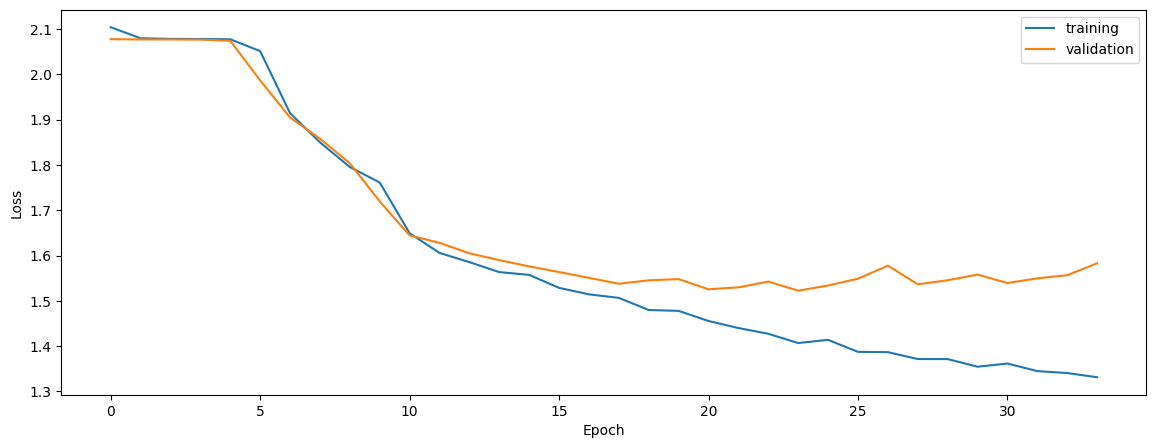

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.4546717579520947


0.4097371941962274


0.36427318114395285


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.3405459906027761


0.34662090353154346


0.23682919421535872


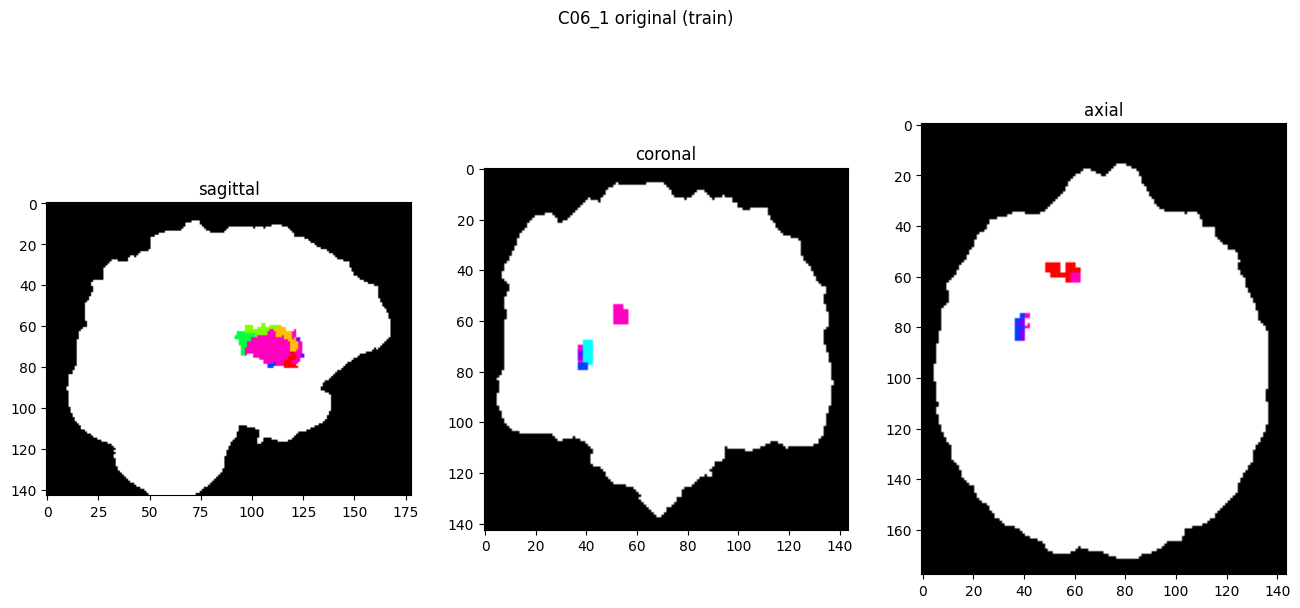

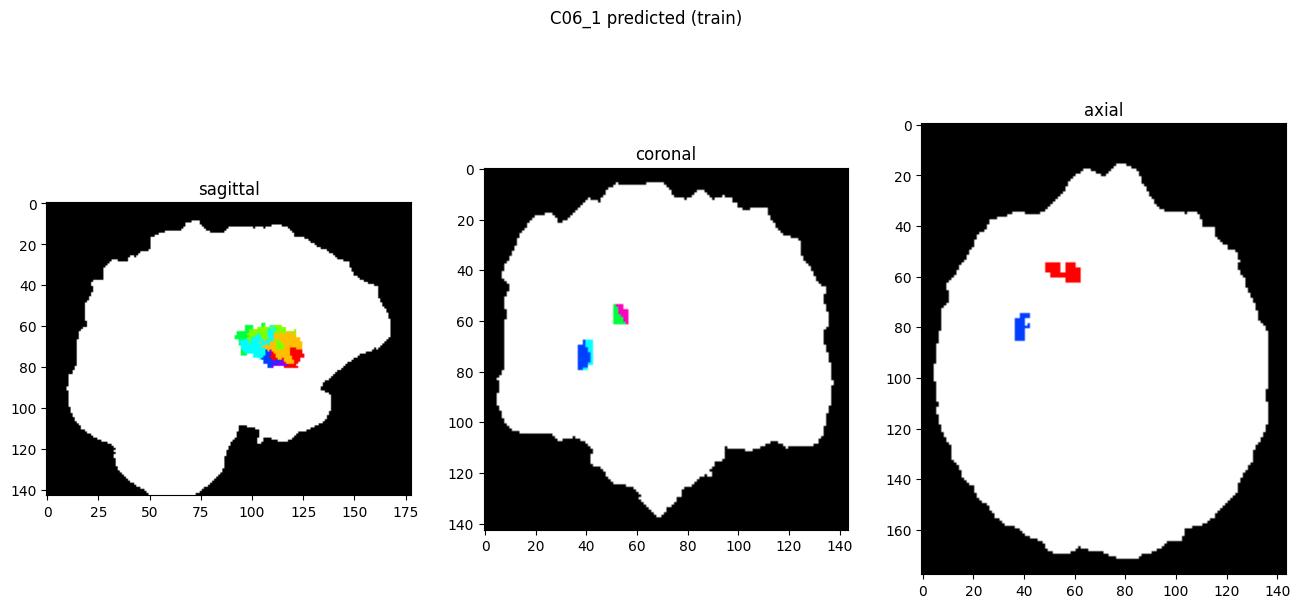

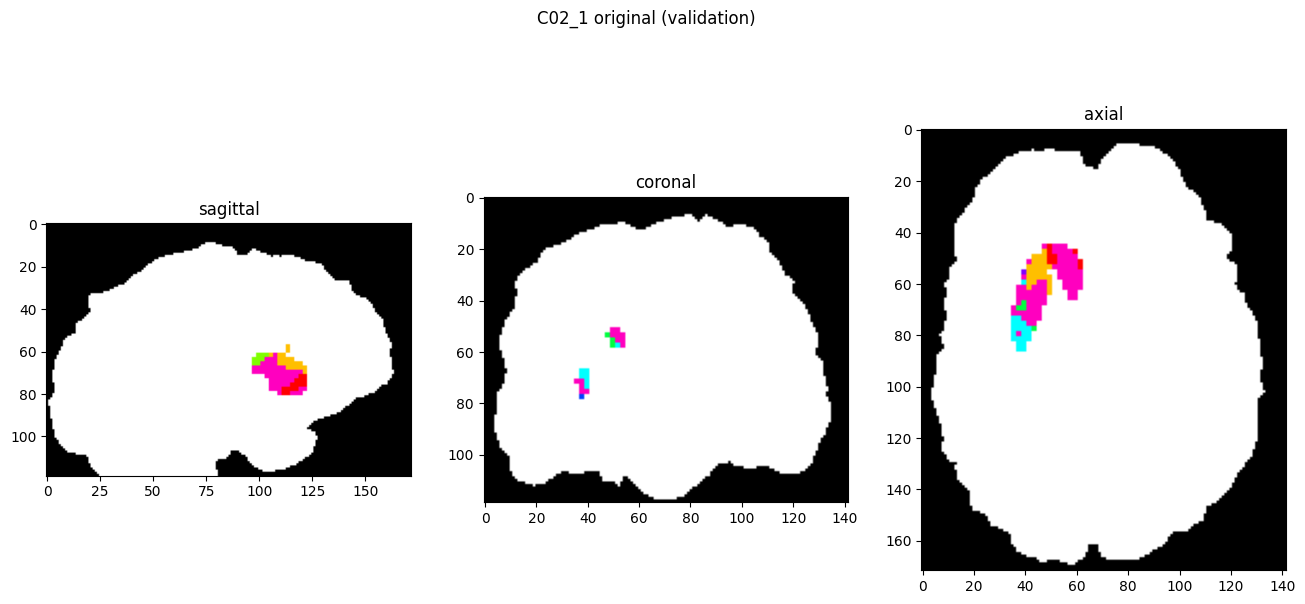

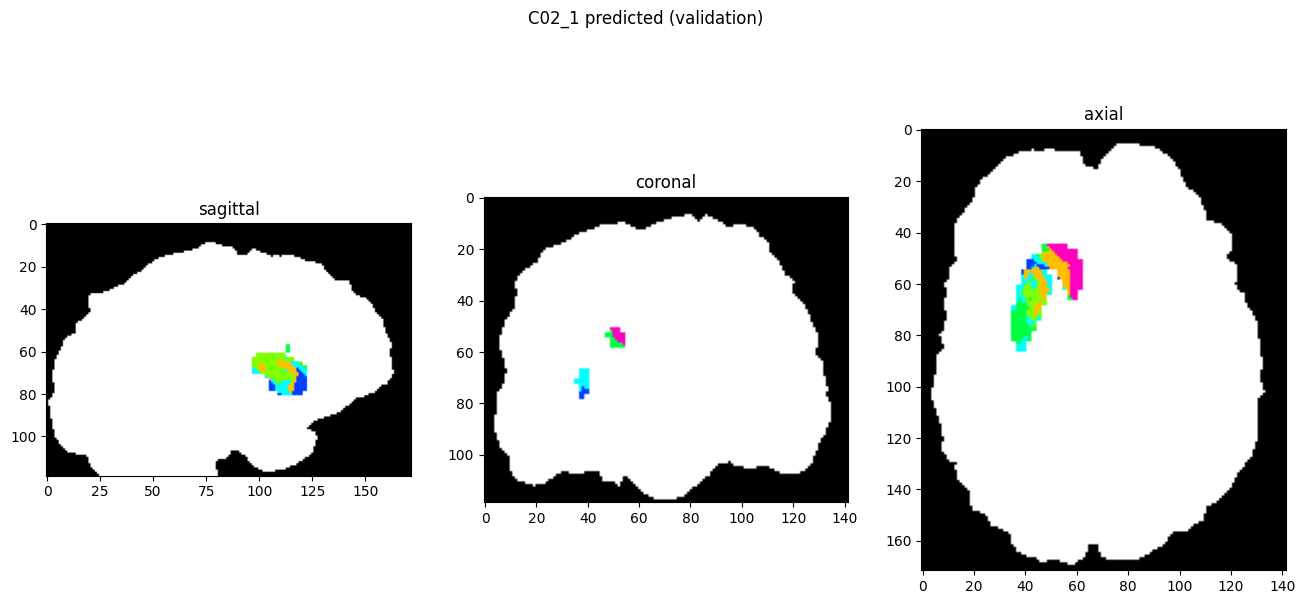

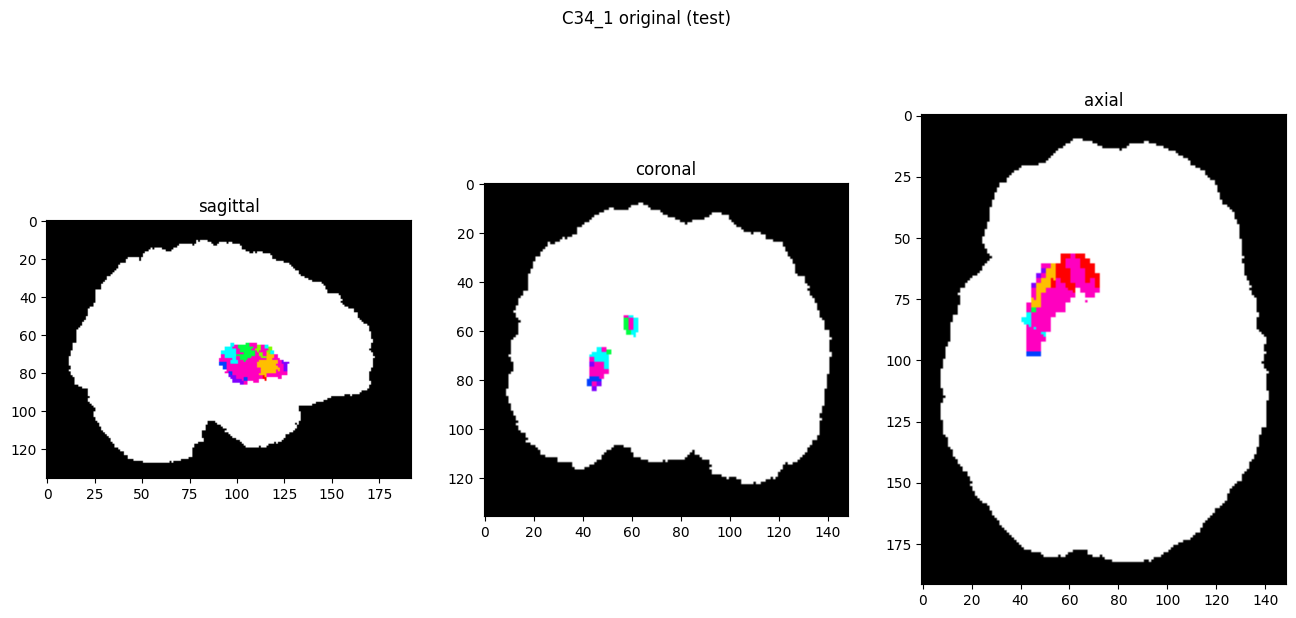

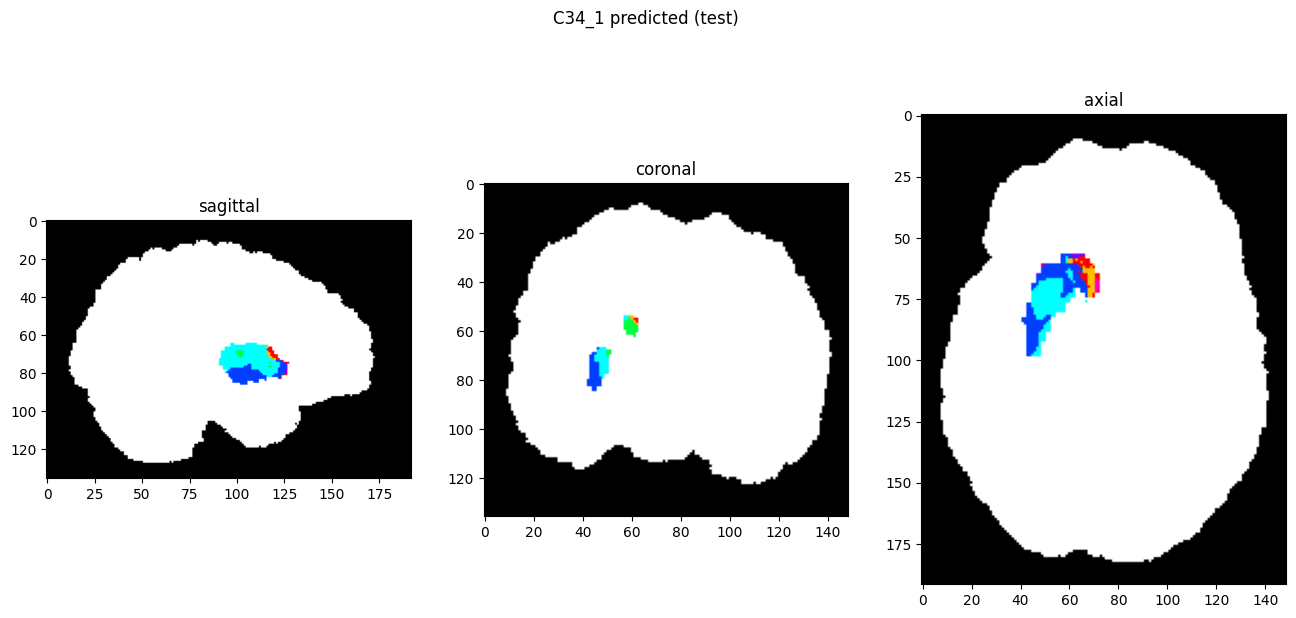

In [9]:
showResults(model, gen, threshold=0)